# Modeling the Data

_Ashish Kumar Mishra_

A notebook for modeling the spotify skip prediction data.

During the feature engineering process, I wanted to add in features in order to account for a user's past preferences during a "listening session." My first idea was to average the past values for the tracks that the user _listened to_ and tat the user _skipped_, so the model could essentially compare the current song's features to the average _skip_ features and the average _listen_ features. I initially had some issues with leaking target information when doing this via pandas vectorized methods, so I decided to forgo the efficient approach in favor of an approach that I knew was right. This notebook has an alternate approach, in which I give the model the previous song's features and whether or not they were skipped – rather than feature averages – which can be calculated _much much_ faster and ended up getting equivalent performance.

In [3]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
path = "/content/drive/MyDrive/Technocolab Project/train_data.csv"
training_set = pd.read_csv(path)

In [6]:
training_set.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,premium,context_type_catalog,context_type_charts,context_type_editorial_playlist,context_type_personalized_playlist,context_type_radio,context_type_user_collection,hist_user_behavior_reason_start_appload,hist_user_behavior_reason_start_backbtn,hist_user_behavior_reason_start_clickrow,hist_user_behavior_reason_start_endplay,hist_user_behavior_reason_start_fwdbtn,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,hist_user_behavior_reason_end_appload,hist_user_behavior_reason_end_backbtn,hist_user_behavior_reason_end_clickrow,hist_user_behavior_reason_end_endplay,hist_user_behavior_reason_end_fwdbtn,hist_user_behavior_reason_end_logout,hist_user_behavior_reason_end_remote,hist_user_behavior_reason_end_trackdone
0,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.000000,1.0,t_1a73002a-d065-4a33-b98a-a3b0443310be,1,1,1,0,0,0,0,0,-0.164915,-0.165319,0,0.608696,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.052632,1.0,t_1a73002a-d065-4a33-b98a-a3b0443310be,0,0,0,0,0,0,0,1,4.621190,-0.165319,0,0.608696,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.105263,1.0,t_16bc2816-8daf-449a-a0f7-93ee884ffdda,0,1,1,0,0,0,1,1,-0.164915,-0.165319,0,0.608696,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.157895,1.0,t_71d34c2f-1c87-43df-83ba-00832e12194c,0,1,1,0,0,1,0,0,-0.164915,-0.165319,0,0.608696,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.210526,1.0,t_a66ea088-b357-449a-8a1e-64dd0b8d6cb5,0,1,1,0,1,1,0,0,-0.164915,-0.165319,0,0.608696,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [7]:
# Loading Track features
path = "/content/drive/MyDrive/Technocolab Project/track_feats.csv"
track_data = pd.read_csv(path)

In [8]:
track_data.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,is_major,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_7f435320-5d3b-497d-9346-0c97429af2b9,3.866097,0.441176,-0.403765,0.075846,0.499848,0.494943,0.461215,-0.208611,0.563252,0.916317,3.736224e-01,0.0,0.693975,-1.877277,0.187614,1,0.576942,0.065943,0.500154,0.571429,0.468440,1.034540,-1.040880,-1.281460,-0.375163,1.442307,0.045940,-0.443245,-0.243705
1,t_2a7b6393-ebec-4e1f-a53f-2ad842532c99,1.512969,0.308824,0.314153,0.085482,0.450139,0.457034,0.663219,-0.305010,0.767307,0.942687,1.000551e-06,0.0,0.290537,0.688374,0.549348,1,0.324341,0.046754,-0.461603,0.571429,0.655369,0.834594,-0.653568,-0.483168,-0.538935,1.247153,0.414248,-0.468285,-0.931875
2,t_949441c4-4920-4eed-b929-2d67d37b7bd9,-1.332280,0.485294,0.001032,0.002274,0.243778,0.229295,0.290262,-1.181899,0.958647,0.846197,5.658840e-02,0.0,0.259133,0.182698,0.332016,1,0.472339,0.115356,1.081277,0.571429,0.293100,0.846650,0.123691,-2.692681,-0.770798,1.533066,-0.173705,-0.402540,1.181761
3,t_63eae5ac-744a-46ee-b719-0db8e70d6f7f,-0.712162,0.485294,0.558944,0.005024,0.338580,0.331703,0.348846,-0.795663,0.886674,0.904784,1.998796e-10,0.0,0.381728,0.091084,0.185455,1,0.575982,0.137590,-0.657413,0.571429,0.387131,0.920349,0.335177,-2.631787,-1.033223,1.549514,-0.036511,-0.488062,1.028883
4,t_a0747d21-6042-4af7-a21d-aa7cd1a8094e,-1.629474,0.573529,-0.356946,0.962717,0.130125,0.092335,0.170027,-2.024206,0.005674,1.072822,9.604511e-01,0.0,0.092290,-5.961527,0.205882,1,0.882453,0.039092,-1.431127,0.428571,0.030858,2.238796,-3.259609,-2.378984,1.288895,-1.053248,-3.132837,0.946820,-0.623612


In [9]:
track_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316702 entries, 0 to 316701
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   track_id                316702 non-null  object 
 1   duration                316702 non-null  float64
 2   release_year            316702 non-null  float64
 3   us_popularity_estimate  316702 non-null  float64
 4   acousticness            316702 non-null  float64
 5   beat_strength           316702 non-null  float64
 6   bounciness              316702 non-null  float64
 7   danceability            316702 non-null  float64
 8   dyn_range_mean          316702 non-null  float64
 9   energy                  316702 non-null  float64
 10  flatness                316702 non-null  float64
 11  instrumentalness        316702 non-null  float64
 12  key                     316702 non-null  float64
 13  liveness                316702 non-null  float64
 14  loudness            

In [10]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2323212 entries, 0 to 2323211
Data columns (total 40 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   session_id                                  object 
 1   session_position                            float64
 2   session_length                              float64
 3   track_id_clean                              object 
 4   skip_1                                      int64  
 5   skip_2                                      int64  
 6   skip_3                                      int64  
 7   not_skipped                                 int64  
 8   context_switch                              int64  
 9   no_pause_before_play                        int64  
 10  short_pause_before_play                     int64  
 11  long_pause_before_play                      int64  
 12  hist_user_behavior_n_seekfwd                float64
 13  hist_user_behavior_n_seekba

In [11]:
# Convert the columns to all be consistantly numeric
track_data.iloc[:,1:] = track_data.iloc[:,1:].astype('float32')
track_data.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,is_major,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_7f435320-5d3b-497d-9346-0c97429af2b9,3.866097,0.441176,-0.403765,0.075846,0.499848,0.494943,0.461215,-0.208611,0.563252,0.916317,3.736224e-01,0.0,0.693975,-1.877277,0.187614,1.0,0.576942,0.065943,0.500154,0.571429,0.468440,1.034540,-1.040880,-1.281460,-0.375163,1.442307,0.045940,-0.443245,-0.243705
1,t_2a7b6393-ebec-4e1f-a53f-2ad842532c99,1.512969,0.308824,0.314153,0.085482,0.450139,0.457034,0.663219,-0.305010,0.767307,0.942687,1.000551e-06,0.0,0.290537,0.688374,0.549348,1.0,0.324341,0.046754,-0.461603,0.571429,0.655369,0.834594,-0.653568,-0.483167,-0.538935,1.247153,0.414248,-0.468285,-0.931875
2,t_949441c4-4920-4eed-b929-2d67d37b7bd9,-1.332280,0.485294,0.001032,0.002274,0.243778,0.229295,0.290262,-1.181899,0.958647,0.846197,5.658840e-02,0.0,0.259133,0.182698,0.332016,1.0,0.472339,0.115356,1.081277,0.571429,0.293100,0.846650,0.123691,-2.692681,-0.770798,1.533066,-0.173705,-0.402540,1.181761
3,t_63eae5ac-744a-46ee-b719-0db8e70d6f7f,-0.712162,0.485294,0.558944,0.005024,0.338580,0.331703,0.348846,-0.795663,0.886674,0.904784,1.998796e-10,0.0,0.381728,0.091084,0.185455,1.0,0.575982,0.137590,-0.657413,0.571429,0.387131,0.920349,0.335177,-2.631788,-1.033223,1.549514,-0.036511,-0.488062,1.028883
4,t_a0747d21-6042-4af7-a21d-aa7cd1a8094e,-1.629474,0.573529,-0.356946,0.962717,0.130125,0.092335,0.170027,-2.024206,0.005674,1.072822,9.604511e-01,0.0,0.092290,-5.961526,0.205882,1.0,0.882453,0.039092,-1.431127,0.428571,0.030858,2.238796,-3.259609,-2.378984,1.288895,-1.053248,-3.132838,0.946820,-0.623612


In [12]:
# Join the two together
session_data = (
    training_set[['session_id','session_position','track_id_clean', 'not_skipped']]
    .merge(
        track_data,
        how='left',
        left_on=['track_id_clean'],
        right_on=['track_id']
    ).drop(columns='track_id_clean')
)
session_data.head()

,session_id,session_position,not_skipped,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,is_major,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.000000,0,t_1a73002a-d065-4a33-b98a-a3b0443310be,-1.163568,1.0,0.715581,0.011384,0.779074,0.836964,0.901467,2.076821,0.522463,1.040777,7.197583e-08,0.181818,0.259353,-0.060035,0.500000,1.0,0.353645,0.330443,-0.562429,0.571429,0.328722,-1.577071,0.786764,0.806604,0.254515,-0.863171,0.077358,-0.904268,0.592306
1,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.052632,0,t_1a73002a-d065-4a33-b98a-a3b0443310be,-1.163568,1.0,0.715581,0.011384,0.779074,0.836964,0.901467,2.076821,0.522463,1.040777,7.197583e-08,0.181818,0.259353,-0.060035,0.500000,1.0,0.353645,0.330443,-0.562429,0.571429,0.328722,-1.577071,0.786764,0.806604,0.254515,-0.863171,0.077358,-0.904268,0.592306
2,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.105263,0,t_16bc2816-8daf-449a-a0f7-93ee884ffdda,-0.109025,1.0,0.715575,0.190542,0.497857,0.498487,0.687340,-0.174502,0.791714,1.000875,1.404504e-09,0.454545,0.166943,1.187313,0.726688,1.0,0.235591,0.045244,-0.696442,0.571429,0.670523,-0.901194,0.958794,0.716827,-0.343279,-0.641036,0.672574,-0.441026,0.531172
3,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.157895,0,t_71d34c2f-1c87-43df-83ba-00832e12194c,-0.327845,1.0,0.715527,0.696750,0.344195,0.355678,0.552530,-0.649624,0.585964,1.008345,4.460962e-12,1.000000,0.081308,0.385687,0.372493,1.0,0.663033,0.036199,0.188650,0.571429,0.443155,0.193965,0.945955,0.374236,-1.195639,-0.181855,0.975532,-0.513956,-0.527603
4,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.210526,0,t_a66ea088-b357-449a-8a1e-64dd0b8d6cb5,0.202982,1.0,0.715583,0.349092,0.483979,0.487409,0.510576,-0.205536,0.566101,1.038444,1.782869e-10,0.545455,0.340215,0.181127,0.424028,0.0,0.476240,0.199701,-1.231169,0.571429,0.218147,-1.335184,0.884475,0.466910,-0.064535,-0.758634,-0.031635,-1.176805,0.475216


In [13]:
session_data.shape

(2323212, 33)

In [14]:
full_session_data = pd.concat((
    session_data,
    session_data.drop(columns=['track_id'])\
        .groupby('session_id')\
        .shift(1)\
        .rename(columns={c:f"previous_{c}" for c in session_data.columns})
), axis=1)
full_session_data.head()

,session_id,session_position,not_skipped,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,is_major,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,previous_session_position,previous_not_skipped,previous_duration,previous_release_year,previous_us_popularity_estimate,previous_acousticness,previous_beat_strength,previous_bounciness,previous_danceability,previous_dyn_range_mean,previous_energy,previous_flatness,previous_instrumentalness,previous_key,previous_liveness,previous_loudness,previous_mechanism,previous_is_major,previous_organism,previous_speechiness,previous_tempo,previous_time_signature,previous_valence,previous_acoustic_vector_0,previous_acoustic_vector_1,previous_acoustic_vector_2,previous_acoustic_vector_3,previous_acoustic_vector_4,previous_acoustic_vector_5,previous_acoustic_vector_6,previous_acoustic_vector_7
0,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.000000,0,t_1a73002a-d065-4a33-b98a-a3b0443310be,-1.163568,1.0,0.715581,0.011384,0.779074,0.836964,0.901467,2.076821,0.522463,1.040777,7.197583e-08,0.181818,0.259353,-0.060035,0.500000,1.0,0.353645,0.330443,-0.562429,0.571429,0.328722,-1.577071,0.786764,0.806604,0.254515,-0.863171,0.077358,-0.904268,0.592306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.052632,0,t_1a73002a-d065-4a33-b98a-a3b0443310be,-1.163568,1.0,0.715581,0.011384,0.779074,0.836964,0.901467,2.076821,0.522463,1.040777,7.197583e-08,0.181818,0.259353,-0.060035,0.500000,1.0,0.353645,0.330443,-0.562429,0.571429,0.328722,-1.577071,0.786764,0.806604,0.254515,-0.863171,0.077358,-0.904268,0.592306,0.000000,0.0,-1.163568,1.0,0.715581,0.011384,0.779074,0.836964,0.901467,2.076821,0.522463,1.040777,7.197583e-08,0.181818,0.259353,-0.060035,0.500000,1.0,0.353645,0.330443,-0.562429,0.571429,0.328722,-1.577071,0.786764,0.806604,0.254515,-0.863171,0.077358,-0.904268,0.592306
2,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.105263,0,t_16bc2816-8daf-449a-a0f7-93ee884ffdda,-0.109025,1.0,0.715575,0.190542,0.497857,0.498487,0.687340,-0.174502,0.791714,1.000875,1.404504e-09,0.454545,0.166943,1.187313,0.726688,1.0,0.235591,0.045244,-0.696442,0.571429,0.670523,-0.901194,0.958794,0.716827,-0.343279,-0.641036,0.672574,-0.441026,0.531172,0.052632,0.0,-1.163568,1.0,0.715581,0.011384,0.779074,0.836964,0.901467,2.076821,0.522463,1.040777,7.197583e-08,0.181818,0.259353,-0.060035,0.500000,1.0,0.353645,0.330443,-0.562429,0.571429,0.328722,-1.577071,0.786764,0.806604,0.254515,-0.863171,0.077358,-0.904268,0.592306
3,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.157895,0,t_71d34c2f-1c87-43df-83ba-00832e12194c,-0.327845,1.0,0.715527,0.696750,0.344195,0.355678,0.552530,-0.649624,0.585964,1.008345,4.460962e-12,1.000000,0.081308,0.385687,0.372493,1.0,0.663033,0.036199,0.188650,0.571429,0.443155,0.193965,0.945955,0.374236,-1.195639,-0.181855,0.975532,-0.513956,-0.527603,0.105263,0.0,-0.109025,1.0,0.715575,0.190542,0.497857,0.498487,0.687340,-0.174502,0.791714,1.000875,1.404504e-09,0.454545,0.166943,1.187313,0.726688,1.0,0.235591,0.045244,-0.696442,0.571429,0.670523,-0.901194,0.958794,0.716827,-0.343279,-0.641036,0.672574,-0.441026,0.531172
4,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.210526,0,t_a66ea088-b357-449a-8a1e-64dd0b8d6cb5,0.202982,1.0,0.715583,0.349092,0.483979,0.487409,0.510576,-0.205536,0.566101,1.038444,1.782869e-10,0.545455,0.340215,0.181127,0.424028,0.0,0.476240,0.199701,-1.231169,0.571429,0.218147,-1.335184,0.884475,0.466910,-0.064535,-0.758634,-0.031635,-1.176805,0.475216,0.157895,0.0,-0.327845,1.0,0.715527,0.696750,0.344195,0.355678,0.552530,-0.649624,0.585964,1.008345,4.460962e-12,1.000000,0.081308,0.385687,0.372493,1.0,0.663033,0.036199

In [15]:
# Examine the columns
full_session_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2323212 entries, 0 to 2323211
Data columns (total 64 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   session_id                       object 
 1   session_position                 float64
 2   not_skipped                      int64  
 3   track_id                         object 
 4   duration                         float32
 5   release_year                     float32
 6   us_popularity_estimate           float32
 7   acousticness                     float32
 8   beat_strength                    float32
 9   bounciness                       float32
 10  danceability                     float32
 11  dyn_range_mean                   float32
 12  energy                           float32
 13  flatness                         float32
 14  instrumentalness                 float32
 15  key                              float32
 16  liveness                         float32
 17  loudness

In [16]:
full_session_data = full_session_data.dropna()

In [17]:
full_session_data.shape

(2183612, 64)

In [18]:
full_session_data.isnull().sum()

session_id                    0
session_position              0
not_skipped                   0
track_id                      0
duration                      0
                             ..
previous_acoustic_vector_3    0
previous_acoustic_vector_4    0
previous_acoustic_vector_5    0
previous_acoustic_vector_6    0
previous_acoustic_vector_7    0
Length: 64, dtype: int64

In [19]:
# Split the data:
# df -> X, y -> Train, Test, Val
X = full_session_data.drop(
    columns=["not_skipped","session_id","track_id"]
).fillna(-9999)
y = full_session_data.not_skipped
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=2
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=2
)
X.head(5)

,session_position,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,is_major,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,previous_session_position,previous_not_skipped,previous_duration,previous_release_year,previous_us_popularity_estimate,previous_acousticness,previous_beat_strength,previous_bounciness,previous_danceability,previous_dyn_range_mean,previous_energy,previous_flatness,previous_instrumentalness,previous_key,previous_liveness,previous_loudness,previous_mechanism,previous_is_major,previous_organism,previous_speechiness,previous_tempo,previous_time_signature,previous_valence,previous_acoustic_vector_0,previous_acoustic_vector_1,previous_acoustic_vector_2,previous_acoustic_vector_3,previous_acoustic_vector_4,previous_acoustic_vector_5,previous_acoustic_vector_6,previous_acoustic_vector_7
1,0.052632,-1.163568,1.0,0.715581,0.011384,0.779074,0.836964,0.901467,2.076821,0.522463,1.040777,7.197583e-08,0.181818,0.259353,-0.060035,0.500000,1.0,0.353645,0.330443,-0.562429,0.571429,0.328722,-1.577071,0.786764,0.806604,0.254515,-0.863171,0.077358,-0.904268,0.592306,0.000000,0.0,-1.163568,1.0,0.715581,0.011384,0.779074,0.836964,0.901467,2.076821,0.522463,1.040777,7.197583e-08,0.181818,0.259353,-0.060035,0.500000,1.0,0.353645,0.330443,-0.562429,0.571429,0.328722,-1.577071,0.786764,0.806604,0.254515,-0.863171,0.077358,-0.904268,0.592306
2,0.105263,-0.109025,1.0,0.715575,0.190542,0.497857,0.498487,0.687340,-0.174502,0.791714,1.000875,1.404504e-09,0.454545,0.166943,1.187313,0.726688,1.0,0.235591,0.045244,-0.696442,0.571429,0.670523,-0.901194,0.958794,0.716827,-0.343279,-0.641036,0.672574,-0.441026,0.531172,0.052632,0.0,-1.163568,1.0,0.715581,0.011384,0.779074,0.836964,0.901467,2.076821,0.522463,1.040777,7.197583e-08,0.181818,0.259353,-0.060035,0.500000,1.0,0.353645,0.330443,-0.562429,0.571429,0.328722,-1.577071,0.786764,0.806604,0.254515,-0.863171,0.077358,-0.904268,0.592306
3,0.157895,-0.327845,1.0,0.715527,0.696750,0.344195,0.355678,0.552530,-0.649624,0.585964,1.008345,4.460962e-12,1.000000,0.081308,0.385687,0.372493,1.0,0.663033,0.036199,0.188650,0.571429,0.443155,0.193965,0.945955,0.374236,-1.195639,-0.181855,0.975532,-0.513956,-0.527603,0.105263,0.0,-0.109025,1.0,0.715575,0.190542,0.497857,0.498487,0.687340,-0.174502,0.791714,1.000875,1.404504e-09,0.454545,0.166943,1.187313,0.726688,1.0,0.235591,0.045244,-0.696442,0.571429,0.670523,-0.901194,0.958794,0.716827,-0.343279,-0.641036,0.672574,-0.441026,0.531172
4,0.210526,0.202982,1.0,0.715583,0.349092,0.483979,0.487409,0.510576,-0.205536,0.566101,1.038444,1.782869e-10,0.545455,0.340215,0.181127,0.424028,0.0,0.476240,0.199701,-1.231169,0.571429,0.218147,-1.335184,0.884475,0.466910,-0.064535,-0.758634,-0.031635,-1.176805,0.475216,0.157895,0.0,-0.327845,1.0,0.715527,0.696750,0.344195,0.355678,0.552530,-0.649624,0.585964,1.008345,4.460962e-12,1.000000,0.081308,0.385687,0.372493,1.0,0.663033,0.036199,0.188650,0.571429,0.443155,0.193965,0.945955,0.374236,-1.195639,-0.181855,0.975532,-0.513956,-0.527603
5,0.263158,0.202982,1.0,0.715583,0.349092,0.483979,0.487409,0.510576,-0.205536,0.566101,1.038444,1.782869e-10,0.545455,0.340215,0.181127,0.424028,0.0,0.476240,0.199701,-1.231169,0.571429,0.218147,-1.335184,0.884475,0.466910,-0.064535,-0.758634,-0.031635,-1.176805,0.475216,0.210526,0.0,0.202982,1.0,0.715583,0.349092,0.483979,0.487409,0.510576,-0.205536,0.566101,1.038444,1.782869e-10,0.545455,0.340215,0.181127,0.424028,0.0,0.476240,0.199701,-1.231169,0.571429,0.218147,-1.335184,0.884475,0.466910,-0.064535,-0.758634,-0.031635,-1.176805,0.475216


In [23]:
X.columns

Index(['session_position', 'duration', 'release_year',
       'us_popularity_estimate', 'acousticness', 'beat_strength', 'bounciness',
       'danceability', 'dyn_range_mean', 'energy', 'flatness',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mechanism',
       'is_major', 'organism', 'speechiness', 'tempo', 'time_signature',
       'valence', 'acoustic_vector_0', 'acoustic_vector_1',
       'acoustic_vector_2', 'acoustic_vector_3', 'acoustic_vector_4',
       'acoustic_vector_5', 'acoustic_vector_6', 'acoustic_vector_7',
       'previous_session_position', 'previous_not_skipped',
       'previous_duration', 'previous_release_year',
       'previous_us_popularity_estimate', 'previous_acousticness',
       'previous_beat_strength', 'previous_bounciness',
       'previous_danceability', 'previous_dyn_range_mean', 'previous_energy',
       'previous_flatness', 'previous_instrumentalness', 'previous_key',
       'previous_liveness', 'previous_loudness', 'previous_mechanism',


In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
# Train a Logistic Regression model and score
scaler = StandardScaler().fit(X_train)
sX_train = scaler.transform(X_train)
sX_val = scaler.transform(X_val)
sX_test = scaler.transform(X_test)

log = LogisticRegressionCV(
    cv=3
).fit(
    sX_train,
    y_train
)

print("Log Train score: %s" % log.score(sX_train,y_train))
print("Log Val score:   %s" % log.score(sX_val,y_val))
print("Log Test score:  %s" % log.score(sX_test,y_test))

Log Train score: 0.7541550656846351
Log Val score:   0.7540743836188885
Log Test score:  0.7538874755852107


In [34]:
log

LogisticRegressionCV(Cs=10, class_weight=None, cv=3, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [27]:
for pair in sorted(zip(X.columns,log.coef_[0]),key=lambda p: np.abs(p[1]),reverse=True):
    print("%30s | % .8f" % pair)

          previous_not_skipped |  0.96080176
                      duration | -0.15384790
                 beat_strength |  0.10673820
                    bounciness | -0.08693770
             acoustic_vector_4 |  0.07469928
           previous_bounciness |  0.07444136
    previous_acoustic_vector_0 |  0.07164108
                  release_year |  0.05981910
    previous_acoustic_vector_3 | -0.05800827
             acoustic_vector_2 |  0.05794289
    previous_acoustic_vector_5 | -0.05686774
    previous_acoustic_vector_1 | -0.05382749
        us_popularity_estimate |  0.05235015
             acoustic_vector_5 |  0.04622221
        previous_beat_strength | -0.04279836
             acoustic_vector_0 | -0.04061221
             previous_duration |  0.03943542
             acoustic_vector_3 | -0.03240731
             previous_loudness | -0.03165132
             acoustic_vector_7 |  0.03093200
       previous_dyn_range_mean | -0.02961184
                      organism |  0.02724575
          

In [35]:
# Train a Random Forest model and score
rfc = RandomForestClassifier(
    n_estimators=100
).fit(
    X_train,
    y_train
)

print("RFC Train score: %s" % rfc.score(X_train,y_train))
print("RFC Val score:   %s" % rfc.score(X_val,y_val))
print("RFC Test score:  %s" % rfc.score(X_test,y_test))

RFC Train score: 0.971849237680419
RFC Val score:   0.7376423243592899
RFC Test score:  0.7367003798746574


In [29]:
for pair in sorted(zip(X.columns,rfc.feature_importances_),key=lambda p:p[1],reverse=True):
    print("%30s | % .8f" % pair)

          previous_not_skipped |  0.19848528
     previous_session_position |  0.05602783
              session_position |  0.05592474
                      duration |  0.01606763
previous_us_popularity_estimate |  0.01559478
             previous_duration |  0.01526119
             previous_liveness |  0.01500387
        us_popularity_estimate |  0.01492281
    previous_acoustic_vector_0 |  0.01472206
                previous_tempo |  0.01471382
         previous_acousticness |  0.01462825
    previous_acoustic_vector_1 |  0.01461626
             previous_loudness |  0.01455318
              previous_valence |  0.01441716
    previous_acoustic_vector_2 |  0.01440966
          previous_speechiness |  0.01438980
    previous_acoustic_vector_7 |  0.01422874
             previous_flatness |  0.01418404
               previous_energy |  0.01408220
    previous_acoustic_vector_6 |  0.01401290
    previous_acoustic_vector_4 |  0.01397998
    previous_acoustic_vector_5 |  0.01385111
    previ

In [20]:
# Train a LightGBM model and score
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(
    n_estimators=100000
).fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train),(X_val, y_val)],
    early_stopping_rounds=10,
    verbose=True
)

print()
print("LGBM Train score: %s" % lgbm.score(X_train,y_train))
print("LGBM Val score:   %s" % lgbm.score(X_val,y_val))
print("LGBM Test score:  %s" % lgbm.score(X_test,y_test))

[1]	training's binary_logloss: 0.620735	valid_1's binary_logloss: 0.621175
Training until validation scores don't improve for 10 rounds.
[2]	training's binary_logloss: 0.604747	valid_1's binary_logloss: 0.605218
[3]	training's binary_logloss: 0.591899	valid_1's binary_logloss: 0.592412
[4]	training's binary_logloss: 0.581491	valid_1's binary_logloss: 0.582049
[5]	training's binary_logloss: 0.572994	valid_1's binary_logloss: 0.573586
[6]	training's binary_logloss: 0.56601	valid_1's binary_logloss: 0.56662
[7]	training's binary_logloss: 0.560271	valid_1's binary_logloss: 0.560917
[8]	training's binary_logloss: 0.555555	valid_1's binary_logloss: 0.556241
[9]	training's binary_logloss: 0.551635	valid_1's binary_logloss: 0.552348
[10]	training's binary_logloss: 0.548396	valid_1's binary_logloss: 0.549119
[11]	training's binary_logloss: 0.545721	valid_1's binary_logloss: 0.546476
[12]	training's binary_logloss: 0.543458	valid_1's binary_logloss: 0.544248
[13]	training's binary_logloss: 0.541

LightGBM Classifier performance:
```
LGBM Train score: 0.7605972332239246
LGBM Val score:   0.758218891859247
LGBM Test score:  0.7577411769016058
```

`LGBM` seems to have better performance to `logistic Regression` model (but faster).

Let's examine feature importance...

In [21]:
for pair in sorted(zip(X.columns,lgbm.feature_importances_),key=lambda p:p[1],reverse=True):
    print("%34s | % 5d" % pair)

            us_popularity_estimate |   652
                          duration |   537
   previous_us_popularity_estimate |   427
                       speechiness |   317
                             tempo |   309
                 previous_duration |   303
                           valence |   296
                 acoustic_vector_2 |   293
                  instrumentalness |   284
                      acousticness |   283
                          flatness |   282
                          liveness |   271
                          loudness |   270
                 acoustic_vector_0 |   268
                 acoustic_vector_6 |   264
                  session_position |   259
                 acoustic_vector_5 |   256
                 acoustic_vector_1 |   255
                 acoustic_vector_7 |   249
                      danceability |   247
                 acoustic_vector_4 |   245
        previous_acoustic_vector_1 |   240
        previous_acoustic_vector_0 |   238
           

In [22]:
# Top 10 Features
lgbm_feature_importances = [[p[0], int(p[1])] for p in sorted(zip(X.columns,lgbm.feature_importances_),key=lambda p:p[1],reverse=True)]
lgbm_feature_importances[:10]

[['us_popularity_estimate', 652],
 ['duration', 537],
 ['previous_us_popularity_estimate', 427],
 ['speechiness', 317],
 ['tempo', 309],
 ['previous_duration', 303],
 ['valence', 296],
 ['acoustic_vector_2', 293],
 ['instrumentalness', 284],
 ['acousticness', 283]]

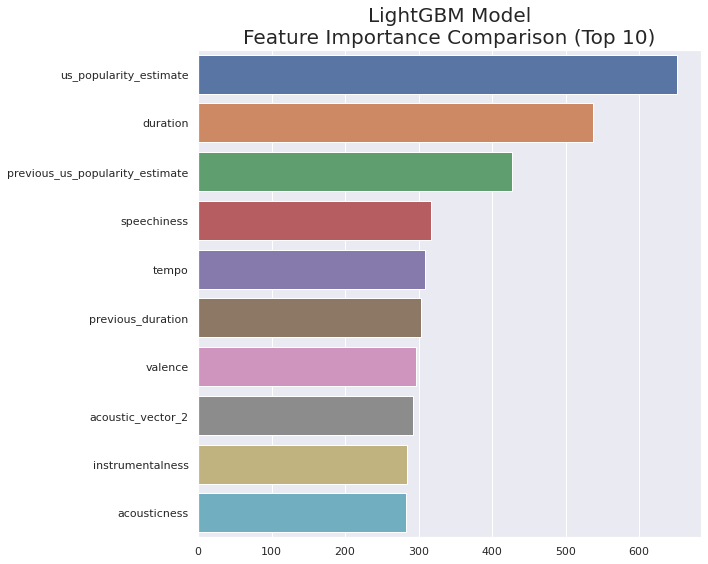

In [25]:
# Plotting the top 10 features
fi = pd.DataFrame(lgbm_feature_importances,columns=['Feature','Importance'])

plt.figure(figsize=(10,8))
sns.barplot(
    "Importance",
    "Feature",
    data=fi.head(10)
)
plt.title(
    "LightGBM Model\nFeature Importance Comparison (Top 10)",
    fontsize=20
)
plt.xlabel(
    "",
    fontsize=15
)
plt.ylabel(
    "",
    fontsize=15
)
# plt.xticks(rotation=90)
plt.tight_layout()

# plt.show()

In [26]:
from sklearn.metrics import confusion_matrix

In [28]:
print("LightGBM Confusion Matrix")
print(confusion_matrix(
    y_test,
    lgbm.predict(X_test)
) / sum(y_test.shape))

LightGBM Confusion Matrix
[[0.55409951 0.10562302]
 [0.13663581 0.20364167]]


In [29]:
# # Save out the model
with open("lgbm_model.pkl","wb") as f:
     pickle.dump(lgbm,f)

In [30]:
# Load in the model
with open("lgbm_model.pkl","rb") as f:
    lgbm = pickle.load(f)

In [31]:
from sklearn.metrics import accuracy_score

In [36]:
def predict_proba(X):
    predictions = (
        log.predict_proba(scaler.transform(X))[:,1] +
        rfc.predict_proba(X)[:,1] +
      
        lgbm.predict_proba(X)[:,1]
    )
    return predictions / 3

def predict(X,threshold=0.5):
    return (predict_proba(X) > threshold).astype('float32')

def score(X,y):
    return accuracy_score(y,predict(X))

print("Ensemble Train Accuracy:  %.3f" % score(X_train,y_train))
print("Ensemble Val Accuracy:    %.3f" % score(X_val,y_val))
print("Ensemble Test Accuracy:   %.3f" % score(X_test,y_test))

Ensemble Train Accuracy:  0.819
Ensemble Val Accuracy:    0.757
Ensemble Test Accuracy:   0.757


In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [38]:
lgbm_preds = lgbm.predict(X_test)

print("LightGBM Test Precision Score: %.3f" % precision_score(y_test,lgbm_preds))
print("LightGBM Test Recall Score:    %.3f" % recall_score(y_test,lgbm_preds))
print("LightGBM Test F1 Score:        %.3f" % f1_score(y_test,lgbm_preds))

LightGBM Test Precision Score: 0.658
LightGBM Test Recall Score:    0.598
LightGBM Test F1 Score:        0.627


In [40]:
ensamble_predictions = predict(X_test)

In [41]:
print("Ensemble Test Precision Score: %.3f" % precision_score(y_test,ensamble_predictions))
print("Ensemble Test Recall Score:    %.3f" % recall_score(y_test,ensamble_predictions))
print("Ensemble Test F1 Score:        %.3f" % f1_score(y_test,ensamble_predictions))

Ensemble Test Precision Score: 0.656
Ensemble Test Recall Score:    0.600
Ensemble Test F1 Score:        0.627


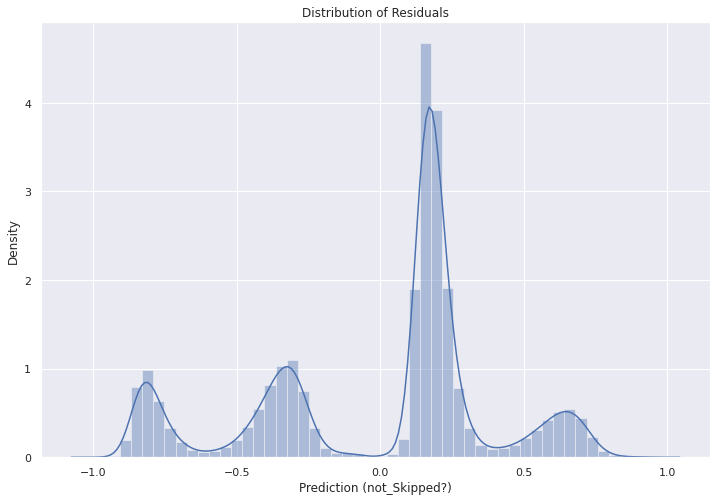

In [43]:
lgbm_probs = lgbm.predict_proba(X_test)[:,1]
lgmb_residuals = (lgbm_probs - y_test).sort_values()

plt.figure(figsize=(12,8))
sns.distplot(lgmb_residuals)
plt.title("Distribution of Residuals")
plt.xlabel("Prediction (not_Skipped?)")
plt.show()

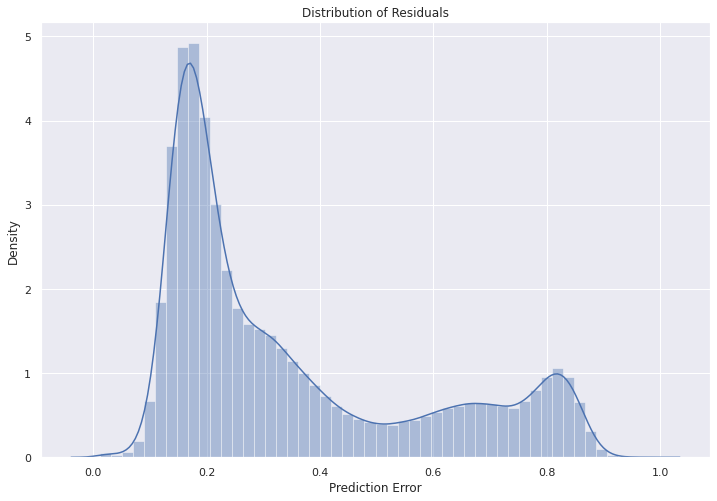

In [44]:
plt.figure(figsize=(12,8))
sns.distplot(np.abs(lgmb_residuals))
plt.title("Distribution of Residuals")
plt.xlabel("Prediction Error")
plt.show()

In [45]:
threshold = 0.6
print("Proportion of Residuals (Greater than %.2f):  %.4f" % (
    threshold,
    (np.abs(lgmb_residuals) > threshold).sum() / lgmb_residuals.count()
))

Proportion of Residuals (Greater than 0.60):  0.1988


In [46]:
target_residuals = np.abs(lgmb_residuals) > threshold
target_residuals = target_residuals.sort_index()
target_residuals.head()

4     False
10    False
12    False
14    False
16    False
Name: not_skipped, dtype: bool

In [47]:
X_test.sort_index().head()

,session_position,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,is_major,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,previous_session_position,previous_not_skipped,previous_duration,previous_release_year,previous_us_popularity_estimate,previous_acousticness,previous_beat_strength,previous_bounciness,previous_danceability,previous_dyn_range_mean,previous_energy,previous_flatness,previous_instrumentalness,previous_key,previous_liveness,previous_loudness,previous_mechanism,previous_is_major,previous_organism,previous_speechiness,previous_tempo,previous_time_signature,previous_valence,previous_acoustic_vector_0,previous_acoustic_vector_1,previous_acoustic_vector_2,previous_acoustic_vector_3,previous_acoustic_vector_4,previous_acoustic_vector_5,previous_acoustic_vector_6,previous_acoustic_vector_7
4,0.210526,0.202982,1.0,0.715583,0.349092,0.483979,0.487409,0.510576,-0.205536,0.566101,1.038444,1.782869e-10,0.545455,0.340215,0.181127,0.424028,0.0,0.476240,0.199701,-1.231169,0.571429,0.218147,-1.335184,0.884475,0.466910,-0.064535,-0.758634,-0.031635,-1.176805,0.475216,0.157895,0.0,-0.327845,1.0,0.715527,0.696750,0.344195,0.355678,0.552530,-0.649624,0.585964,1.008345,4.460962e-12,1.000000,0.081308,0.385687,0.372493,1.0,0.663033,0.036199,0.188650,0.571429,0.443155,0.193965,0.945955,0.374236,-1.195639,-0.181855,0.975532,-0.513956,-0.527603
10,0.526316,-0.442993,1.0,0.715432,0.080196,0.652551,0.686557,0.776092,0.781903,0.735516,1.032662,8.880605e-08,0.636364,0.159249,0.768985,0.837905,1.0,0.127879,0.246829,0.894295,0.571429,0.233484,-1.054778,1.043759,0.470183,-0.245657,-0.758999,0.419770,-0.595940,0.730675,0.473684,0.0,-0.383212,1.0,0.715478,0.115362,0.406843,0.391453,0.593567,-0.619540,0.797661,0.993274,1.532804e-12,0.363636,0.142516,0.627073,0.748111,1.0,0.195904,0.084415,0.698585,0.571429,0.380786,-0.744446,0.683264,0.026049,-0.478112,-0.283149,0.424844,-1.001859,0.494647
12,0.631579,-0.482590,1.0,0.715260,0.372639,0.567604,0.618498,0.714563,0.515622,0.574006,1.033640,6.138596e-11,0.636364,0.173783,0.404324,0.821256,1.0,0.292241,0.081734,1.194780,0.571429,0.337121,-1.402052,0.917371,0.586793,0.016051,-0.646324,-0.027224,-1.248402,0.359594,0.578947,0.0,0.067220,1.0,0.715285,0.010213,0.498266,0.511281,0.637917,-0.080186,0.623816,1.036899,1.375694e-11,0.909091,0.094437,0.598780,0.801484,1.0,0.140557,0.079801,1.292253,0.571429,0.444923,-1.266275,1.070459,0.499138,-0.173246,-0.681390,0.131059,-1.065070,0.473915
14,0.736842,-0.370762,1.0,0.715092,0.081146,0.370766,0.376877,0.631062,-0.593479,0.672097,1.030745,4.697695e-12,1.000000,0.153593,0.775497,0.576023,1.0,0.305238,0.034697,-0.034905,0.571429,0.281719,-1.011115,1.000812,0.400167,-0.360296,-0.566593,0.301099,-0.987682,0.589260,0.684211,0.0,-0.643378,1.0,0.715183,0.032032,0.472703,0.514271,0.641779,0.031895,0.562160,1.024830,2.636095e-10,1.000000,0.168310,0.711277,0.705446,0.0,0.209509,0.081202,1.228001,0.571429,0.176667,-1.263743,1.040824,0.532524,-0.140832,-0.589158,0.235883,-0.957381,0.575388
16,0.842105,-0.701010,1.0,0.715555,0.076917,0.591405,0.586605,0.671390,0.148972,0.528879,1.042076,3.347652e-04,0.000000,0.085625,0.182025,0.866310,1.0,0.109062,0.306538,1.360355,0.571429,0.203130,-1.289834,0.428784,0.172574,0.234164,-0.611737,-0.450886,-1.220879,0.445106,0.789474,0.0,-1.811875,1.0,0.710969,0.930358,0.582524,0.653126,0.558006,0.770545,0.384269,0.987080,6.787698e-05,0.545455,0.603517,-1.259105,0.220779,0.0,0.858123,0.142935,-1.494914,0.571429,0.828793,-0.519376,-1.083556,-0.617375,1.535695,-0.692551,-2.474880,0.090266,-1.044868


In [48]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 436723 entries, 694083 to 1759659
Data columns (total 61 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   session_position                 436723 non-null  float64
 1   duration                         436723 non-null  float32
 2   release_year                     436723 non-null  float32
 3   us_popularity_estimate           436723 non-null  float32
 4   acousticness                     436723 non-null  float32
 5   beat_strength                    436723 non-null  float32
 6   bounciness                       436723 non-null  float32
 7   danceability                     436723 non-null  float32
 8   dyn_range_mean                   436723 non-null  float32
 9   energy                           436723 non-null  float32
 10  flatness                         436723 non-null  float32
 11  instrumentalness                 436723 non-null  float32
 

In [49]:
# Sort the columns by lgbm's feature importance value
columns_to_compare, _ = zip(*sorted(zip(X.columns, lgbm.feature_importances_),key=lambda p:p[1],reverse=True))
columns_to_compare[:10]

('us_popularity_estimate',
 'duration',
 'previous_us_popularity_estimate',
 'speechiness',
 'tempo',
 'previous_duration',
 'valence',
 'acoustic_vector_2',
 'instrumentalness',
 'acousticness')

In [50]:
def plot(column):
    plt.figure(figsize=(8,4))
    sns.distplot(
        X_test[column][target_residuals],
        label="Residual > 0.6"
    )
    sns.distplot(
        X_test[column][~target_residuals],
        label="Residual < 0.6"
    )
    plt.title(f"Distribution of \"{column}\"\nw/ Residual Split")
    plt.show()
    return

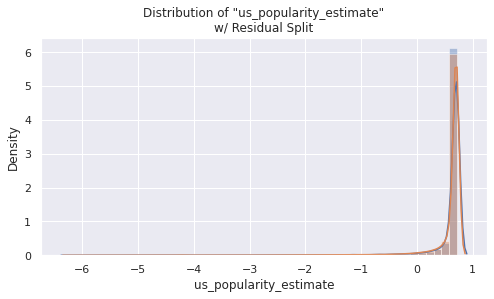

In [51]:
plot("us_popularity_estimate")

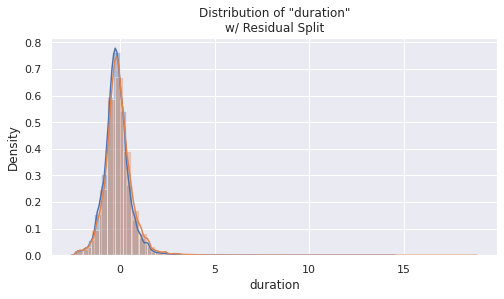

In [52]:
plot("duration")

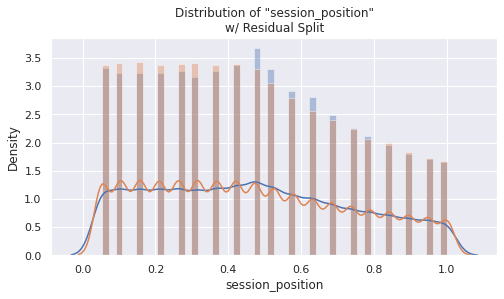

In [53]:
plot("session_position")

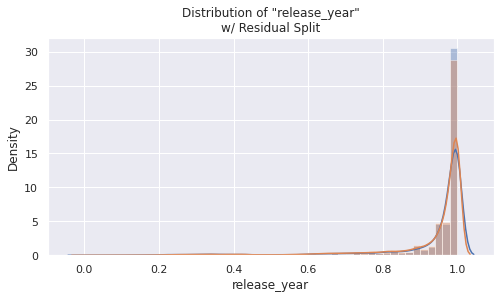

In [54]:
plot("release_year")

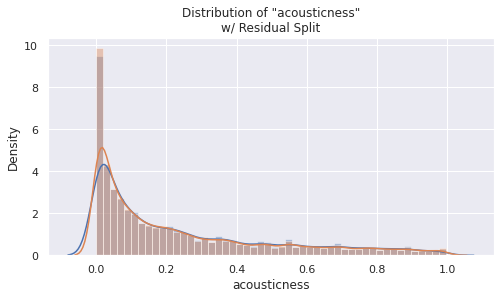

In [55]:
plot("acousticness")

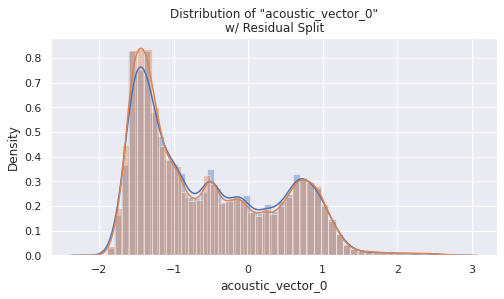

In [56]:
plot("acoustic_vector_0")

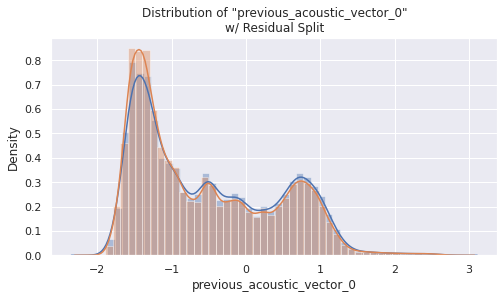

In [57]:
plot("previous_acoustic_vector_0")

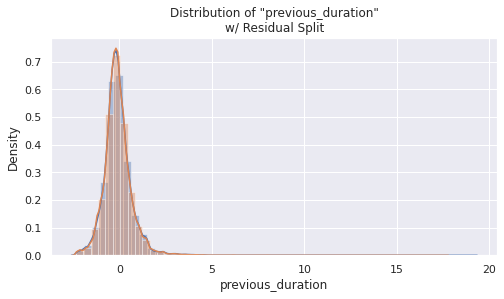

In [58]:
plot("previous_duration")

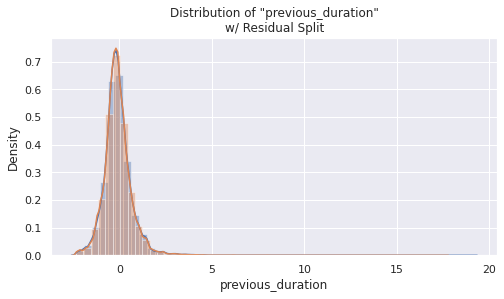

In [59]:
# The N/A value is making it hard to see the main distribution

plt.figure(figsize=(8,4))
sns.distplot(
    X_test["previous_duration"][target_residuals & (X_test["previous_duration"] > -2000)],
    label="Residual > 0.6"
)
sns.distplot(
    X_test["previous_duration"][~target_residuals & (X_test["previous_duration"] > -2000)],
    label="Residual < 0.6"
)
plt.title(f"Distribution of \"{ 'previous_duration' }\"\nw/ Residual Split")
plt.show()

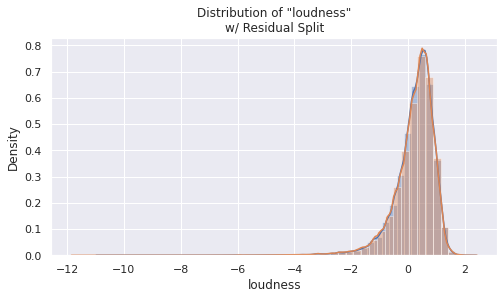

In [60]:
plot("loudness")

***

Adding EDA plots for the presentation: ROC Curve for `Naive model` vs `Logistic Regression` vs `XGB model

In [61]:
log_probs = log.predict_proba(scaler.transform(X_test))[:,1]
lgb_probs = lgbm.predict_proba(X_test)[:,1]

In [62]:
from sklearn.metrics import roc_curve, roc_auc_score

In [63]:
log_fpr, log_tpr, _ = roc_curve(y_test, log_probs)
lgb_fpr, lgb_tpr, _ = roc_curve(y_test, lgb_probs)

Text(0, 0.5, 'TPR')

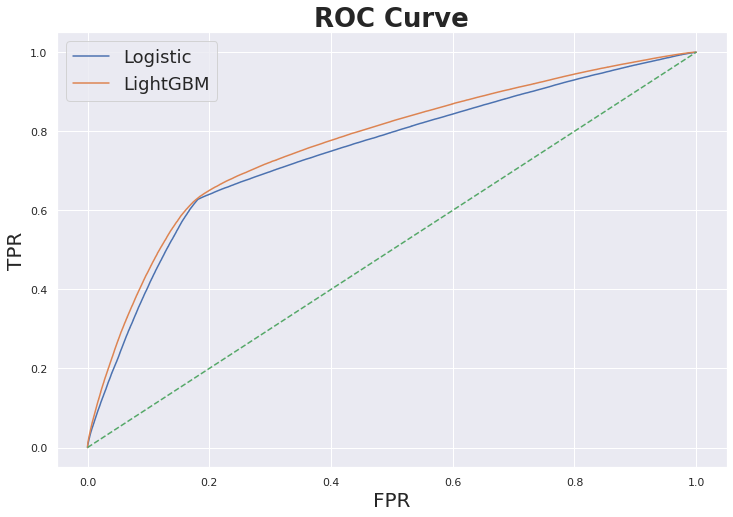

In [64]:
plt.figure(figsize=(12,8))
plt.plot(
    log_fpr,
    log_tpr,
    label="Logistic"
    
)
plt.plot(
    lgb_fpr,
    lgb_tpr,
    label="LightGBM"
)
plt.plot(
    np.linspace(0,1,10),
    np.linspace(0,1,10),
    label="",
    linestyle="dashed"
)
plt.legend(
    fontsize=18
)
plt.title(
    "ROC Curve",
    fontsize=26,
    fontweight='bold'
)
plt.xlabel(
    "FPR",
    fontsize=20
)
plt.ylabel(
    "TPR",
    fontsize=20
)


# plt.show()

***

Now can we make some EDA charts to see what a session might look like...

In [66]:
full_session_data.head()

,session_id,session_position,not_skipped,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,is_major,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,previous_session_position,previous_not_skipped,previous_duration,previous_release_year,previous_us_popularity_estimate,previous_acousticness,previous_beat_strength,previous_bounciness,previous_danceability,previous_dyn_range_mean,previous_energy,previous_flatness,previous_instrumentalness,previous_key,previous_liveness,previous_loudness,previous_mechanism,previous_is_major,previous_organism,previous_speechiness,previous_tempo,previous_time_signature,previous_valence,previous_acoustic_vector_0,previous_acoustic_vector_1,previous_acoustic_vector_2,previous_acoustic_vector_3,previous_acoustic_vector_4,previous_acoustic_vector_5,previous_acoustic_vector_6,previous_acoustic_vector_7
1,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.052632,0,t_1a73002a-d065-4a33-b98a-a3b0443310be,-1.163568,1.0,0.715581,0.011384,0.779074,0.836964,0.901467,2.076821,0.522463,1.040777,7.197583e-08,0.181818,0.259353,-0.060035,0.500000,1.0,0.353645,0.330443,-0.562429,0.571429,0.328722,-1.577071,0.786764,0.806604,0.254515,-0.863171,0.077358,-0.904268,0.592306,0.000000,0.0,-1.163568,1.0,0.715581,0.011384,0.779074,0.836964,0.901467,2.076821,0.522463,1.040777,7.197583e-08,0.181818,0.259353,-0.060035,0.500000,1.0,0.353645,0.330443,-0.562429,0.571429,0.328722,-1.577071,0.786764,0.806604,0.254515,-0.863171,0.077358,-0.904268,0.592306
2,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.105263,0,t_16bc2816-8daf-449a-a0f7-93ee884ffdda,-0.109025,1.0,0.715575,0.190542,0.497857,0.498487,0.687340,-0.174502,0.791714,1.000875,1.404504e-09,0.454545,0.166943,1.187313,0.726688,1.0,0.235591,0.045244,-0.696442,0.571429,0.670523,-0.901194,0.958794,0.716827,-0.343279,-0.641036,0.672574,-0.441026,0.531172,0.052632,0.0,-1.163568,1.0,0.715581,0.011384,0.779074,0.836964,0.901467,2.076821,0.522463,1.040777,7.197583e-08,0.181818,0.259353,-0.060035,0.500000,1.0,0.353645,0.330443,-0.562429,0.571429,0.328722,-1.577071,0.786764,0.806604,0.254515,-0.863171,0.077358,-0.904268,0.592306
3,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.157895,0,t_71d34c2f-1c87-43df-83ba-00832e12194c,-0.327845,1.0,0.715527,0.696750,0.344195,0.355678,0.552530,-0.649624,0.585964,1.008345,4.460962e-12,1.000000,0.081308,0.385687,0.372493,1.0,0.663033,0.036199,0.188650,0.571429,0.443155,0.193965,0.945955,0.374236,-1.195639,-0.181855,0.975532,-0.513956,-0.527603,0.105263,0.0,-0.109025,1.0,0.715575,0.190542,0.497857,0.498487,0.687340,-0.174502,0.791714,1.000875,1.404504e-09,0.454545,0.166943,1.187313,0.726688,1.0,0.235591,0.045244,-0.696442,0.571429,0.670523,-0.901194,0.958794,0.716827,-0.343279,-0.641036,0.672574,-0.441026,0.531172
4,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.210526,0,t_a66ea088-b357-449a-8a1e-64dd0b8d6cb5,0.202982,1.0,0.715583,0.349092,0.483979,0.487409,0.510576,-0.205536,0.566101,1.038444,1.782869e-10,0.545455,0.340215,0.181127,0.424028,0.0,0.476240,0.199701,-1.231169,0.571429,0.218147,-1.335184,0.884475,0.466910,-0.064535,-0.758634,-0.031635,-1.176805,0.475216,0.157895,0.0,-0.327845,1.0,0.715527,0.696750,0.344195,0.355678,0.552530,-0.649624,0.585964,1.008345,4.460962e-12,1.000000,0.081308,0.385687,0.372493,1.0,0.663033,0.036199,0.188650,0.571429,0.443155,0.193965,0.945955,0.374236,-1.195639,-0.181855,0.975532,-0.513956,-0.527603
5,63_0000075d-50c4-4c13-b7d1-e91fdbce83bc,0.263158,0,t_a66ea088-b357-449a-8a1e-64dd0b8d6cb5,0.202982,1.0,0.715583,0.349092,0.483979,0.487409,0.510576,-0.205536,0.566101,1.038444,1.782869e-10,0.545455,0.340215,0.181127,0.424028,0.0,0.476240,0.199701,-1.231169,0.571429,0.218147,-1.335184,0.884475,0.466910,-0.064535,-0.758634,-0.031635,-1.176805,0.475216,0.210526,0.0,0.2029

In [67]:
session_ids = full_session_data.session_id.unique()
session_ids.shape

(139600,)

In [68]:
past_sessions = [
    "0_05eb4c83-e0bd-4e12-b65e-9ccd18b39ef9"
]

In [69]:
rid = np.random.choice(session_ids)
rid

'63_6c709eb6-0b38-4e76-91d9-efd19f99b1bd'

In [70]:
session = full_session_data[full_session_data.session_id == rid]
session

,session_id,session_position,not_skipped,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,is_major,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,previous_session_position,previous_not_skipped,previous_duration,previous_release_year,previous_us_popularity_estimate,previous_acousticness,previous_beat_strength,previous_bounciness,previous_danceability,previous_dyn_range_mean,previous_energy,previous_flatness,previous_instrumentalness,previous_key,previous_liveness,previous_loudness,previous_mechanism,previous_is_major,previous_organism,previous_speechiness,previous_tempo,previous_time_signature,previous_valence,previous_acoustic_vector_0,previous_acoustic_vector_1,previous_acoustic_vector_2,previous_acoustic_vector_3,previous_acoustic_vector_4,previous_acoustic_vector_5,previous_acoustic_vector_6,previous_acoustic_vector_7
989864,63_6c709eb6-0b38-4e76-91d9-efd19f99b1bd,0.052632,0,t_5bbbaef1-6050-4223-929f-c98061d9f655,1.106830,0.294118,0.709492,0.326436,0.618426,0.527753,0.542634,-0.470349,0.529382,0.961487,2.688443e-03,0.636364,0.708920,-0.377317,0.311518,1.0,0.538780,0.030070,-1.190580,0.571429,0.745724,0.843371,-0.705702,-0.454032,-0.481173,1.598789,0.486864,-0.561861,-1.006489,0.000000,0.0,-0.355040,0.411765,0.711058,0.206069,0.586416,0.568809,0.713861,0.023658,0.937216,0.961839,4.177660e-07,0.545455,0.073077,1.142853,0.548387,1.0,0.351012,0.039859,0.103888,0.571429,0.963519,0.424221,-1.223258,0.403523,0.234653,1.503616,-0.064484,-0.609133,-1.349806
989865,63_6c709eb6-0b38-4e76-91d9-efd19f99b1bd,0.105263,0,t_80e96522-78d6-4545-b85e-e59a6ebfeb5d,-0.901878,0.191176,0.709445,0.660822,0.576118,0.578336,0.550206,0.143961,0.853673,0.961704,7.259719e-07,0.272727,0.111696,0.464502,0.431953,1.0,0.616183,0.035998,1.268823,0.571429,0.965415,0.448795,-1.584337,-0.472888,0.953983,1.868065,-1.329474,-0.073901,-1.521769,0.052632,0.0,1.106830,0.294118,0.709492,0.326436,0.618426,0.527753,0.542634,-0.470349,0.529382,0.961487,2.688443e-03,0.636364,0.708920,-0.377317,0.311518,1.0,0.538780,0.030070,-1.190580,0.571429,0.745724,0.843371,-0.705702,-0.454032,-0.481173,1.598789,0.486864,-0.561861,-1.006489
989866,63_6c709eb6-0b38-4e76-91d9-efd19f99b1bd,0.157895,0,t_43412580-78e7-488b-87fc-32a1c4b0a2b1,-0.299347,0.220588,0.704488,0.327950,0.358842,0.325603,0.397083,-0.920557,0.784839,0.899696,4.954539e-03,0.181818,0.062056,-0.254042,0.221402,0.0,0.597397,0.054493,-0.818641,0.571429,0.645854,0.933756,-1.337302,-1.575389,-0.160376,1.918478,-0.477439,-0.651711,-1.012384,0.105263,0.0,-0.901878,0.191176,0.709445,0.660822,0.576118,0.578336,0.550206,0.143961,0.853673,0.961704,7.259719e-07,0.272727,0.111696,0.464502,0.431953,1.0,0.616183,0.035998,1.268823,0.571429,0.965415,0.448795,-1.584337,-0.472888,0.953983,1.868065,-1.329474,-0.073901,-1.521769
989867,63_6c709eb6-0b38-4e76-91d9-efd19f99b1bd,0.210526,0,t_415988e4-9d5b-47c1-9b36-0eab77824581,-0.104583,0.441176,-1.003132,0.112315,0.846559,0.895646,0.932751,2.966168,0.527940,0.915273,3.124641e-01,0.454545,0.163061,0.351332,0.802326,0.0,0.160764,0.160555,-0.366155,0.571429,0.754024,0.075250,-0.744903,0.506426,0.097521,-0.205223,0.304958,-0.053650,0.314758,0.157895,0.0,-0.299347,0.220588,0.704488,0.327950,0.358842,0.325603,0.397083,-0.920557,0.784839,0.899696,4.954539e-03,0.181818,0.062056,-0.254042,0.221402,0.0,0.597397,0.054493,-0.818641,0.571429,0.645854,0.933756,-1.337302,-1.575389,-0.160376,1.918478,-0.477439,-0.651711,-1.012384
989868,63_6c709eb6-0b38-4e76-91d9-efd19f99b1bd,0.263158,0,t_4253a926-6190-4324-830f-a7fcaa57af92,-0.289739,0.367647,0.714544,0.883148,0.349241,0.311856,0.413581,-0.987229,0.160662,1.039537,2.225483e-04,0.636364,0.116746,-3.207258,0.496674,0.0,0.718779,0.031834,1.273602,0.571429,0.423205,1.247043,-0.52574

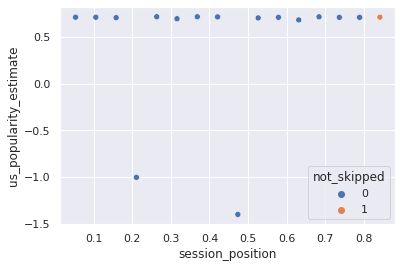

In [71]:
sns.scatterplot(
    session.session_position,
    session.us_popularity_estimate,
    hue=session.not_skipped
)

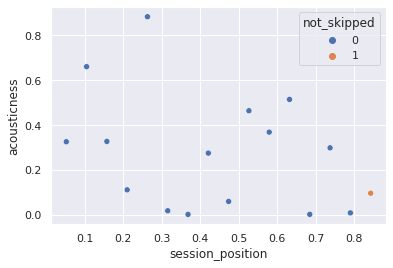

In [72]:
sns.scatterplot(
    session.session_position,
    session.acousticness,
    hue=session.not_skipped
)

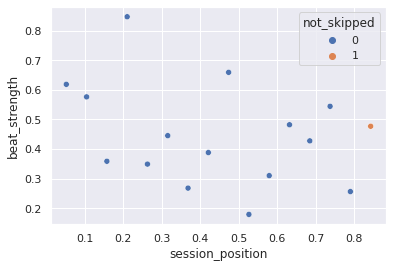

In [73]:
sns.scatterplot(
    session.session_position,
    session.beat_strength,
    hue=session.not_skipped
)

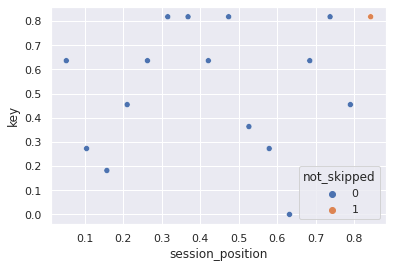

In [74]:
sns.scatterplot(
    session.session_position,
    session.key,
    hue=session.not_skipped
)

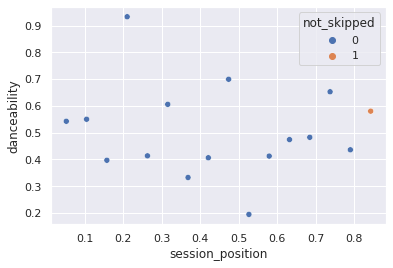

In [75]:
sns.scatterplot(
    session.session_position,
    session.danceability,
    hue=session.not_skipped
)

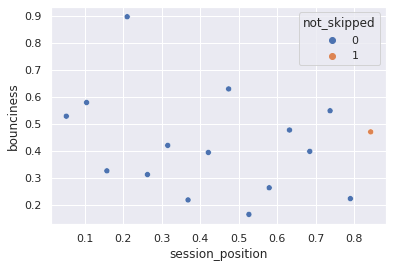

In [76]:
sns.scatterplot(
    session.session_position,
    session.bounciness,
    hue=session.not_skipped
)

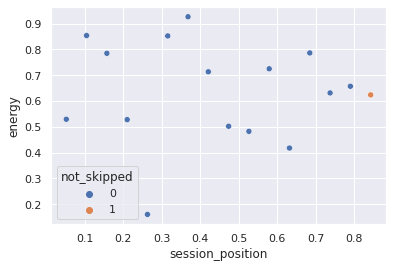

In [77]:
sns.scatterplot(
    session.session_position,
    session.energy,
    hue=session.not_skipped
)

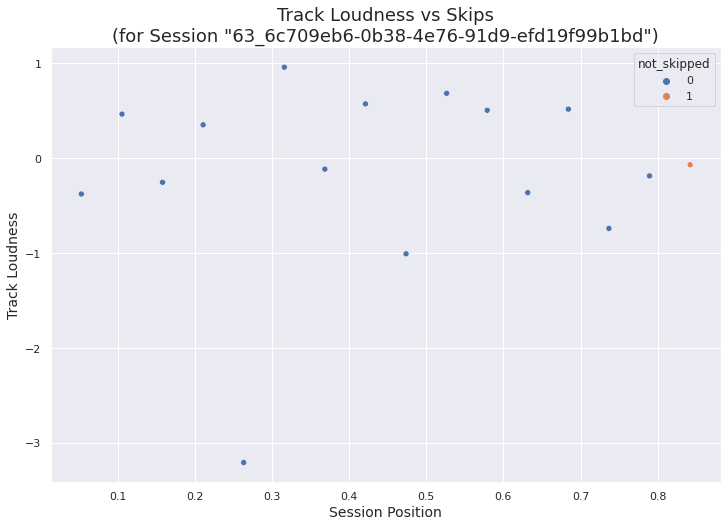

In [78]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    session.session_position,
    session.loudness,
    hue=session.not_skipped
)
plt.title(
    f"Track Loudness vs Skips\n(for Session \"{rid}\")",
    fontsize=18
)
plt.xlabel(
    "Session Position",
    fontsize=14
)
plt.ylabel(
    "Track Loudness",
    fontsize=14
)
# plt.savefig(f"images/session_eda/session_{rid}_loudness.png")
plt.show()

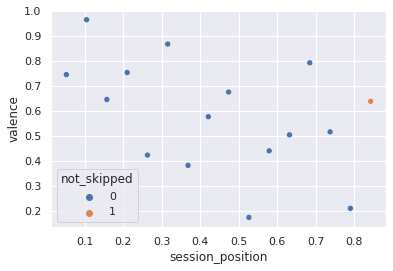

In [79]:
sns.scatterplot(
    session.session_position,
    session.valence,
    hue=session.not_skipped
)

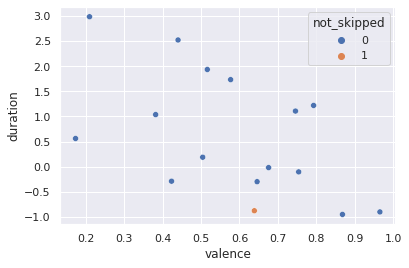

In [80]:
sns.scatterplot(
    session.valence,
    session.duration,
    hue=session.not_skipped
)

In [81]:
full_session_data.not_skipped.sum() / full_session_data.not_skipped.count()

0.33987036158438405

In [82]:
acoustic = {
    "Willie Nelson": 0.48,
    "Wu-Tang Clan": 0.032,
    "John Coltrane": 0.732
    }

Text(0.5, 0, 'Acousticness')

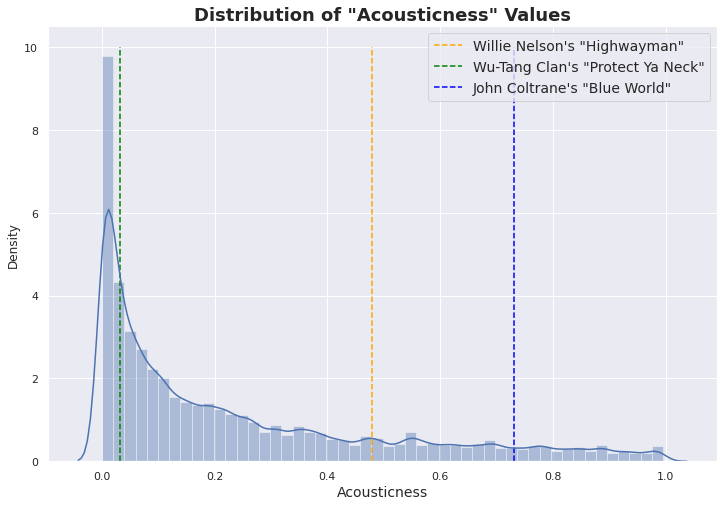

In [83]:
plt.figure(figsize=(12,8))
sns.distplot(
    full_session_data.acousticness
)
plt.title(
    "Distribution of \"Acousticness\" Values",
    fontweight='bold',
    fontsize=18
)

plt.vlines(
    0.48,
    0,
    10,
    label="Willie Nelson's \"Highwayman\"",
    colors='orange',
    linestyles='dashed'
)
plt.vlines(
    0.032,
    0,
    10,
    label="Wu-Tang Clan's \"Protect Ya Neck\"",
    colors='green',
    linestyles='dashed'
)
plt.vlines(
    0.732,
    0,
    10,
    label="John Coltrane's \"Blue World\"",
    colors='blue',
    linestyles='dashed'
)
plt.legend(
    fontsize=14
)
plt.xlabel(
    "Acousticness",
    fontsize=14
)

# plt.show()

Text(0.5, 0, 'Danceability')

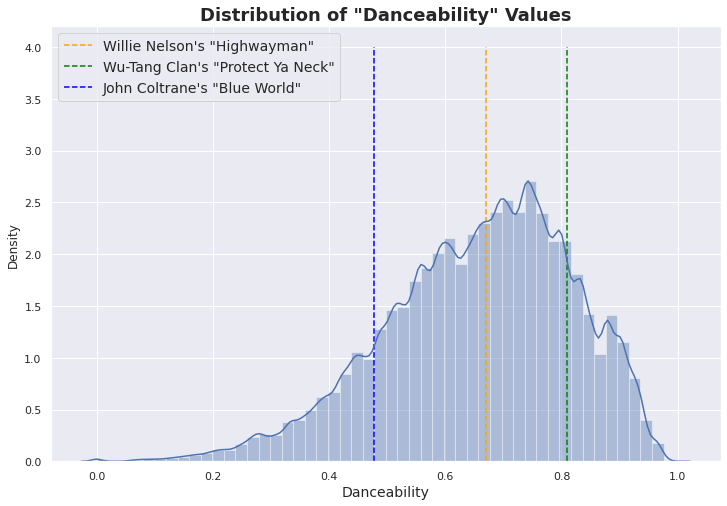

In [84]:
plt.figure(figsize=(12,8))
sns.distplot(
    full_session_data.danceability
)
plt.title(
    "Distribution of \"Danceability\" Values",
    fontweight='bold',
    fontsize=18
)

plt.vlines(
    0.67,
    0,
    4,
    label="Willie Nelson's \"Highwayman\"",
    colors='orange',
    linestyles='dashed'
)
plt.vlines(
    0.81,
    0,
    4,
    label="Wu-Tang Clan's \"Protect Ya Neck\"",
    colors='green',
    linestyles='dashed'
)
plt.vlines(
    0.477,
    0,
    4,
    label="John Coltrane's \"Blue World\"",
    colors='blue',
    linestyles='dashed'
)
plt.legend(
    fontsize=14,
    loc=2
)
plt.xlabel(
    "Danceability",
    fontsize=14
)

# plt.show()

Text(0.5, 0, 'Loudness')

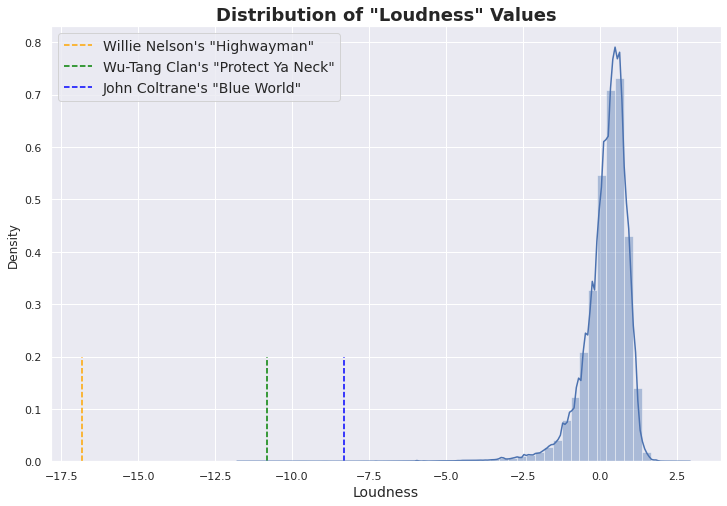

In [85]:
plt.figure(figsize=(12,8))
sns.distplot(
    full_session_data.loudness
)
plt.title(
    "Distribution of \"Loudness\" Values",
    fontweight='bold',
    fontsize=18
)

plt.vlines(
    -16.842,
    0,
    0.2,
    label="Willie Nelson's \"Highwayman\"",
    colors='orange',
    linestyles='dashed'
)
plt.vlines(
    -10.8,
    0,
    0.2,
    label="Wu-Tang Clan's \"Protect Ya Neck\"",
    colors='green',
    linestyles='dashed'
)
plt.vlines(
    -8.301,
    0,
    0.2,
    label="John Coltrane's \"Blue World\"",
    colors='blue',
    linestyles='dashed'
)
plt.legend(
    fontsize=14,
    loc=2
)
plt.xlabel(
    "Loudness",
    fontsize=14
)

# plt.show()

Text(0.5, 0, 'Energy')

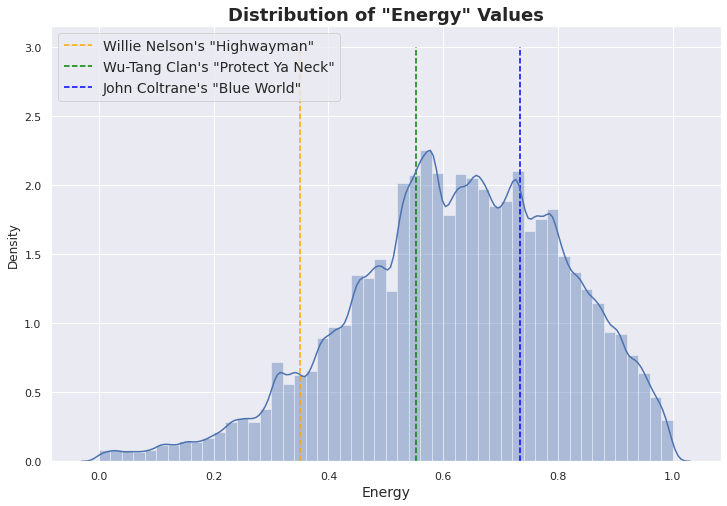

In [86]:
plt.figure(figsize=(12,8))
sns.distplot(
    full_session_data.energy
)
plt.title(
    "Distribution of \"Energy\" Values",
    fontweight='bold',
    fontsize=18
)

plt.vlines(
    0.351,
    0,
    3,
    label="Willie Nelson's \"Highwayman\"",
    colors='orange',
    linestyles='dashed'
)
plt.vlines(
    0.552,
    0,
    3,
    label="Wu-Tang Clan's \"Protect Ya Neck\"",
    colors='green',
    linestyles='dashed'
)
plt.vlines(
    0.733,
    0,
    3,
    label="John Coltrane's \"Blue World\"",
    colors='blue',
    linestyles='dashed'
)
plt.legend(
    fontsize=14,
    loc=2
)
plt.xlabel(
    "Energy",
    fontsize=14
)

# plt.show()